# Creating a DB of image features in `torchvision`

In this use-case, we demonstrate how to use a pre-trained network from `torchvision` to generate
image features for images which are automatically downloaded into MongoDB

In [ ]:
!curl http://images.cocodataset.org/zips/val2014.zip -O val2014.zip
!unzip - qq val2014.zip

As usual, we instantiate the `Datalayer` like this

In [1]:
import pymongo
from superduperdb import superduper
from superduperdb.datalayer.mongodb.query import Collection

collection = Collection('coco')

db = pymongo.MongoClient().documents

db = superduper(db)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


We then add all of the image URIs to MongoDB. The URIs can be a mixture of local file paths (`file://...`), web URLs (`http...`) and
s3 URIs (`s3://...`). After adding the URIs, SuperDuperDB loads their content into MongoDB - no additional
overhead or job definition required.

In [ ]:
import glob
import random

from superduperdb.core.document import Document as D
from superduperdb.encoders.pillow.image import pil_image as i

uris = random.sample([f'file://{x}' for x in glob.glob('val2014/*.jpg')], 6000)

db.execute(collection.insert_many([D({'img': i(uri=uri)}) for uri in uris], encoders=(i,)))[:5000]

We can verify that the images were correctly stored in the `Datalayer`:

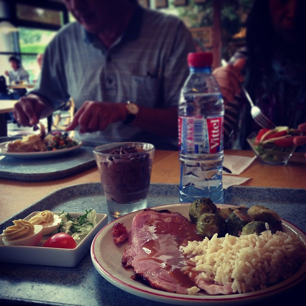

In [4]:
from IPython.display import display

# Jupyter often crashes with bigger images
display_image = lambda x: display(x.resize((round(x.size[0] * 0.5), round(x.size[1] * 0.5))))

x = db.execute(collection.find_one())['img'].x

display_image(x)

Now let's create the `torch`+`torchvision` model using the `TorchModel` wrapper from SuperDuperDB.
It's possible to create arbitrary pre- and post-processing along with the model forward pass:

In [2]:
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.models as models

import warnings

from superduperdb.models.torch.wrapper import TorchModel
from superduperdb.encoders.torch.tensor import tensor

t = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def preprocess(x):
    try:
        return t(x)
    except Exception as e:
        warnings.warn(str(e))
        return torch.zeros(3, 224, 224)

resnet50 = models.resnet50(pretrained=True)
modules = list(resnet50.children())[:-1]
resnet50 = nn.Sequential(*modules)

model = TorchModel(
    identifier='resnet50',
    preprocess=preprocess,
    object=resnet50,
    postprocess=lambda x: x[:, 0, 0],
    encoder=tensor(torch.float, shape=(2048,))
)

/Users/dodo/SuperDuperDB/superduperdb/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dodo/SuperDuperDB/superduperdb/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let's verify `model` by testing on a single data-point `one=True`:

In [6]:
model.predict(x, one=True)

tensor([0.2991, 1.3023, 0.3892,  ..., 0.4763, 1.0383, 0.0398])

Now that we've got the model ready, we can apply it to the images in the `Datalayer`:

In [12]:
model.predict(
    X='img',
    db=db,
    select=collection.find(),
    batch_size=10,
    max_chunk_size=3000,
    in_memory=False,
    watch=True,
)

Computing chunk 0/1


  0%|                                                                                                                                                                 | 0/300 [00:00<?, ?it/s]/var/folders/y9/b74b9yj906s_wtj0rrh2lf7c0000gn/T/ipykernel_4454/166781457.py:22: UserWarning: Unexpected type <class 'superduperdb.misc.special_dicts.MongoStyleDict'>
  warnings.warn(str(e))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [10:40<00:00,  2.13s/it]


Computing chunk 1/1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [07:06<00:00,  2.13s/it]


Let's verify that the features were stored in the `Datalayer`. You can see them in the
`_outputs.img.resnet50` field: 

In [20]:
db.execute(collection.find_one()).unpack()

{'_id': ObjectId('64c68c967a74a3dfc2f443fc'),
 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x612>,
 '_fold': 'train',
 '_outputs': {'img': {'resnet50': tensor([0.4083, 0.0232, 0.0508,  ..., 0.0674, 0.0383, 0.0123])}}}